# Jupyter Notebook for Problem Set 4
Troubleshooting: **Kernel -> Restart and Clear Output** resets the notebook state.

In [2]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Building up the phase portrait

- Make a stream plot.
- Add fixed points.
- Unstable manifolds (for each saddle point):
    - Compute the Jacobian matrix evaluated at that saddle point.
    - Find the unstable eigendirection.
    - Create initial conditions very close to the fixed point, with a small component of the unstable eigendirection added.
    - Create initial conditions very close to the fixed point, with a small component of the unstable eigendirection subtracted.
    - Numerically integrate from those initial conditions using the full nonlinear system.  In forwards time, trajectories approach the unstable manifold branches so if we start near them the trajectory will approximate them.
    - Cut off integration at a fixed time or when the trajectory leaves a set region.
    - Add those trajectories to the phase portrait.
- Stable manifolds (also for each saddle point):
    - Using the Jacobian from above, find the stable eigendirection.
    - Create initial conditions very close to the fixed point, with a small component of the stable eigendirection added.
    - Create initial conditions very close to the fixed point, with a small component of the stable eigendirection subtracted.
    - Numerically integrate from those initial conditions using the backwards-time version of the full nonlinear system.  In backwards time, the stable manifold branches become unstable manifold branches, and nearby trajectories will approach them.
    - Cut off integration at a fixed time or when the trajectory leaves a set region.
    - Add those trajectories to the phase portrait.

Text(0, 0.5, 'Y')

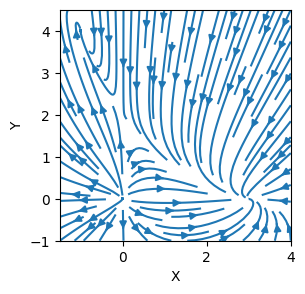

In [3]:
# Make the stream plot.
Y, X = np.mgrid[-1:4.5:100j, -1.5:4:100j]
f_X = X*(3-X-Y)
f_Y = Y*(2-2*X-Y)

# set the figure size
fig = plt.figure(figsize=(3,3))

# Plot 1
ax = fig.add_subplot(1,1,1) 

ax.streamplot(X, Y, f_X, f_Y)

# set the aspect ratio so the x and y scales are the same
ax.set_aspect('equal', adjustable='box')

# add axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')



### Add fixed points and their stability information

In [4]:
# add fixed points shaded by stability

# find the fixed points
x, y = sym.symbols('x y')
f1 = x*(3-x-y)  
f2 = y*(2-2*x-y)
f = [f1, f2]
jacobian = sym.Matrix(f).jacobian([x, y])
fixedpoints = sym.solve([f1, f2], [x, y])

Tr = sym.trace(jacobian)
Det = sym.det(jacobian)

# determine stability
stable = []
unstable = []
saddle = []
for fp in fixedpoints:
    tr = Tr.subs({x: fp[0],y: fp[1]})
    det = Det.subs({x: fp[0],y: fp[1]})
    if tr < 0 and det > 0:
        stable.append(fp)
    else:
        unstable.append(fp)
        if det < 0:
            saddle.append(fp)


# add the fixed points to the plot
x_vals, y_vals = zip(*stable)
ax.plot(x_vals, y_vals, 'ko', markersize=6)

x_vals, y_vals = zip(*unstable)  
ax.plot(x_vals, y_vals, 'ko', markersize=6,markerfacecolor="none")


# We'll wait to display the figure so comment out `fig` command
#fig

### Find the unstable and stable eigendirections for the saddle point
We perturb away from the saddle point slightly in the unstable direction and integrate forward in time to create trajectories that approximate the unstable manifolds.

In [5]:
import numpy as np

# given a saddle point, find initial conditions to approximate the stable and unstable manifold branches
fp = saddle[0]

# make the jacobian a numpy array, rather than working in sympy.
J_fp = np.array(
    sym.Matrix(jacobian.subs({x: fp[0], y: fp[1]})).evalf(),
    dtype=float
)

# find eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(J_fp)

# find the indices of stable and unstable eigenvectors
idx_unstable = np.argmax(eigvals.real)
idx_stable   = np.argmin(eigvals.real)

# find the unstable and stable directions
v_uns = eigvecs[:, idx_unstable]
v_st  = eigvecs[:, idx_stable]

# normalize the vectors to length 1
v_uns = v_uns / np.linalg.norm(v_uns)
v_st  = v_st  / np.linalg.norm(v_st)


eps = 0.01
fp_np = np.array(fp)

# perturb the fixed point a little bit using
#   the eigenvector directions to create 4 new initial conditions
ic_tuple_uns1 = tuple(fp_np + eps * v_uns)
ic_tuple_uns2 = tuple(fp_np - eps * v_uns)
ic_tuple_s1   = tuple(fp_np + eps * v_st)
ic_tuple_s2   = tuple(fp_np - eps * v_st)



### Add forward time trajectories that approximate the unstable manifolds

In [6]:
# assume ic_tuple_uns1 and ic_tuple_uns2 are defined.
# Include an event function in case it is needed (in case one of the trajectories grows towards infinity)

def ode_func(t, u):
    x, y = u
    f1 = (3 - x - y) * x  
    f2 = (2 - 2*x - y) * y
    return [f1, f2]

# Stop integration if |y| reaches ymax by making an event function
def make_blowup_event(ymax):
    def blowup_event(t, y):
        return ymax - abs(y[0])
    blowup_event.terminal = True
    blowup_event.direction = -1
    return blowup_event

# Create the event function
eventfcn = make_blowup_event(ymax=5.0)

t_span = [0, 20]

sol1 = solve_ivp(ode_func, t_span, ic_tuple_uns1, dense_output=True)
sol2 = solve_ivp(ode_func, t_span, ic_tuple_uns2, dense_output=True)

# Plot 1
t_list = np.arange(t_span[0],t_span[1],0.01)
y_list = sol1.sol(t_list)
ax.plot(y_list[0], y_list[1], color='b')
y_list = sol2.sol(t_list)
ax.plot(y_list[0], y_list[1], color='b')

# We'll wait to display the figure so comment out `fig` command
#fig

## Add backward time trajectories that approximate the stable manifolds

In [7]:
# To reverse time, use [-f1, -f2] instead of [f1,f2] as the system
# For this numerical integration, one of the trajectories is going to infinity so we run into blow up, 
# and need to use an event function.
def ode_func(t, u):
    x, y = u
    f1 = (3 - x - y) * x  
    f2 = (2 - 2*x - y) * y
    return [-f1, -f2]

# Stop integration if |x| or |y| reaches xymax by making an event function
def make_blowup_event(xymax):
    def blowup_event(t, y):
        return (xymax - abs(y[0]))*(xymax-abs(y[1]))
    blowup_event.terminal = True
    blowup_event.direction = -1
    return blowup_event

# Create the event function
eventfcn = make_blowup_event(xymax=5.0)

t_span = [0, 5]

# Time grid
t_list = np.arange(t_span[0],t_span[1],0.01)

sol1 = solve_ivp(ode_func,
                    [t_list.min(), t_list.max()],
                    ic_tuple_s1,
                    events=eventfcn)
                   # t_eval=t_list)   # specify output times

sol2 = solve_ivp(ode_func,
                    [t_list.min(), t_list.max()],
                    ic_tuple_s2,
                    events=eventfcn,
                    t_eval=t_list)   # specify output times

# Plot 1
ax.plot(sol1.y[0], sol1.y[1], color='r')
ax.plot(sol2.y[0], sol2.y[1], color='r')

# We'll wait to display the figure so comment out `fig` command
#fig

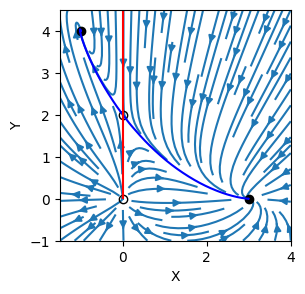

In [8]:
# Show the figure
ax.set_ylim(-1, 4.5)
ax.set_xlim(-1.5, 4)
fig